## Step 2: Run visibility fit by forward-modeling with RADMC-3D (ray tracing) and GALARIO (for FFT) through emcee package

Review what the belt looks like, and use it to inform the choice of parameters and the setup for the fit. <br> Start this script in the target's main directory (workingdir+'/'+sourcetag) from Step 1.

In [1]:
import numpy as np
import pickle
import os

#Start from target's main directory from Step 1
os.chdir('/d1/boudica1/lmatra/GJ14')

#Read in directories as defined in step 1
miaopath, casapath, sourcetag, workingdir, vis, nvis = pickle.load(open('./dirvises.npy','rb'))
os.chdir('./imaging')

Open CASA viewer to display the belt, and keep it open inform your choice of parameters below.


In [2]:
%%script bash -s "$casapath" --bg
$1/casaviewer

Define a few FIXED parameters for the fit

In [3]:
Lstar=0.111  #Stellar luminosity, in Solar luminosities, for blackbody temperature calculation
dist=14.7  #distance to the star, in pc
imsize=24.0     #size (diameter) of the image you want to calculate the radiative transfer over, in arcsec.
#Make sure it includes all emission from the disk, but be wary of making it too large as ray-tracing becomes too expensive

Define disk starting parameters, and priors. This is for a belt with radially Gaussian surface density distribution,
and vertically Gaussian number density distribution, e.g. Matra et al. 2019b, Sect. 4.2, and Eq. 1. <br>
$$ \rho=\Sigma_0\ e^{-\frac{(r-r_{\rm c})^2}{2\sigma^2}}\frac{e^{-\frac{z^2}{2(hr)^2}}}{\sqrt{2\pi}hr} $$<br>
*Note that rho_0 in Eq. of the paper should really be in surface density units, so should have been represented as a Sigma_0 in the paper.* <br>
*Also note this is NOT the same as a belt with a radial density, rather than surface density, distribution, in which the sqrt{2pi}hr normalization would not be present*

In [4]:
#Flux scaling
fluxdensity=1.8e-3 #Total flux density of the belt, in Jy
fluxdensity_dwn, fluxdensity_up = [0.1e-3, 50e-3] #Lower and upper bounds on its prior

#Radial parameters
rmid=99.0/dist # Radial peak location of Gaussian surface density, arcsec
rmid_dwn, rmid_up = [0.3, 12.0]
sigma=32.0/2.35/dist #standard deviation of radial Gaussian surface density
sigma_dwn, sigma_up = [0.05, 'halfrmid'] #halfrmid is special setup that enables the maximum sigma to be half whatever 
#rmid is in current model evaluation.

#Vertical parameters
useh=True  #Do you want to leave the vertical aspect ratio as a free parameter? Only worth it for belts that you 
#believe have a chance to be vertically resolved
if useh:
    h=0.05 #aspect ratio of belt, constant with radius according to the equation above.
    h_dwn, h_up = [0.005, 0.2]
else:
    h=0.03

#Geometry parameters
incl=65.0 #inclination, degrees from face-on
incl_dwn, incl_up = [0.1, 89.99]
posang=5.5 #position angle, East of North. **Needs to be between 0 and 180 degrees!**
#Here below set priors in a way that your position angle is not at the edge of the prior distribution. 
#No need to modify these priors.
if posang<45.0 or posang>135.0:
    posang_dwn, posang_up = [-90.0, 90.0]
    if posang>135.0:
        posang-=180.0
else:
    posang_dwn, posang_up = [0.0, 180.0]
    
#Add star if wanted/needed. This will be located at the geometrical center of the belt.
star=True
if star:
    fstar=4e-5 #star's flux density, in Jy
    fstar_dwn, fstar_up = [1e-6, 2e-3]

Define dataset-dependent parameters: the offsets of the (star+)belt system from the phase center of the observation (dRA and dDec), and the weight factor by which to multiply all visibility weights of each dataset. <br>
The latter is necessary to ensure the measurement uncertainty on each visibility is correct, and therefore that the uncertainties derived on the parameters of the fit are correct. This is not very expensive to do as the values of these weight factors converge very quickly.

In [5]:
if nvis>1: 
    #If you have more than one visibility dataset to fit, define lists - rather than values - of starting 
    #parameters and priors
    dRA=[-0.07,0.1,0.1] #RA offset of star+disk from phase center of observations. 
    ###Remember, RA is positive to the right in the CASA viewer image!###
    dRA_dwn=[-3.0,-3.0,-3.0]
    dRA_up=[3.0,3.0,3.0]
    dDec=[0.14,-0.1,-0.1] #Dec offset of star+disk from phase center of observations
    dDec_dwn=[-3.0,-3.0,-3.0]
    dDec_up=[3.0,3.0,3.0]
    wtfact=[0.289,0.289,1e-4] #factors by which incorrect weights should be multiplied by.
    #This is typically a value between 0.2 and 0.8 for later ALMA Cycles (>~3, but depends on the CASA version used for
    #reduction), around 1 (i.e. weights should be correct) for SMA data. For early ALMA Cycles, this factor comes out 
    #very low, something between 1e-5 and a few times 1e-4 (i.e. weights are largely overestimated by CASA).
    wtfact_dwn=[1e-6,1e-6,1e-6]
    wtfact_up=[10.0,10.0,10.0]
else:
    dRA=[-0.07] #RA offset of star+disk from phase center of observations
    dRA_dwn=[-3.0]
    dRA_up=[3.0]
    dDec=[0.14] #Dec offset of star+disk from phase center of observations
    dDec_dwn=[-3.0]
    dDec_up=[3.0]
    wtfact=[0.289] #factors by which incorrect weights should be multiplied by
    wtfact_dwn=[1e-6]
    wtfact_up=[10.0]
#This below should be set to False if no weight factor is to be applied. Not fully tested as 'False',
# but in general you should always want to check your visiblity weights, so leave as True.
want_wtfact=True

Here below add background sources (galaxies?) that happen to lie in the field and can affect the modelling. <br>
There can be more than 1, and these can be point sources or resolved. If you deem them to be resolved, set resolved=True and model them as a simple inclined 2D Gaussian. <br>
Note that the number of parameters quickly increases if you have many resolved galaxies! Which will slow down your fit.

In [6]:
ngal=0 #Number of galaxies in the field to be modelled.
if ngal>=1:
    resolved=[True, False, False] # if deemed resolved, use 2D Gaussian as galaxy model (6 free parameters), and set 
    #resolved=True for that galaxy. 
    #Otherwise, use point source (3 free parameters) by setting resolved=False.
    fbkg=[285e-6,500e-6,500e-6] #Total flux density of galaxy (galaxies) (Jy)
    fbkg_dwn=[1e-6,1e-6,1e-6]
    fbkg_up=[10e-3,10e-3,10e-3]
    dRAbkg=[2.97,2.97,2.97] # RA offset of galaxy (galaxies) from center of star+disk system. Note that this WILL NOT
    #account for proper motion of the star+disk between datasets taken at different times, 
    #since the offset is fixed for all datasets.
    dRAbkg_dwn=[x-3.0 for x in dRAbkg]
    dRAbkg_up=[x+3.0 for x in dRAbkg]
    dDecbkg=[1.81,1.81,1.81] # Dec offset of galaxy (galaxies) from center of star+disk system. Note that this WILL NOT
    #account for proper motion of the star+disk between datasets taken at different times, 
    #since the offset is fixed for all datasets.
    dDecbkg_dwn=[x-3.0 for x in dDecbkg]
    dDecbkg_up=[x+3.0 for x in dDecbkg]
    sigmagal=[0.3,0,0] # standard deviation (arcsec) of Gaussian used to describe the bkg source
    sigmagal_dwn=[0.05,0.05,0.05]
    sigmagal_up=[1.0,1.0,1.0]
    PAgal=[28.0,0,0] # PA (deg), East of North. **Needs to be between 0 and 180 degrees!**
    #Set prior bounds on PA in a smart way, as done for the disk.
    PAgal_dwn=[]
    PAgal_up=[]
    for i in PAgal:
        if i<45.0 or i>135.0:
            PAgal_dwn.append(-90.0)
            PAgal_up.append(90.0)
        else:
            PAgal_dwn.append(0.0)
            PAgal_up.append(180.0)   
    incgal=[49.0,0,0] # inclination of the bkg source from face-on (degrees)
    incgal_dwn=[0.1,0.1,0.1]
    incgal_up=[89.99,89.99,89.99]
else: 
    resolved=None
    fbkg=None
    dRAbkg=None
    dDecbkg=None
    sigmagal=None
    PAgal=None
    incgal=None

Create needed folders for fitting, check that the imaging has been carried out as we need the primary beam for fitting.

In [11]:
if not os.path.exists(workingdir+'/'+sourcetag+'/imaging'):
    sys.exit('Carry out imaging first: need .pb primary beam image')
for i in ['uvfit']:
    if not os.path.exists(workingdir+'/'+sourcetag+'/'+i):
        os.mkdir(workingdir+'/'+sourcetag+'/'+i)
!cp -r {miaopath}/utils/setup_mcmc.py {workingdir}/{sourcetag}/uvfit/. 
!cp -r {miaopath}/utils/problem_setup_cont_gauss.py {workingdir}/{sourcetag}/uvfit/.  
!cp -r {miaopath}/utils/dustkappa_10445.micr.inp {workingdir}/{sourcetag}/uvfit/. 

Now dump (pickle) array containing all initial fit parameters, as defined above.

NB DO NOT MODIFY ORDER AS OTHERWISE FITTING CODE WILL NOT RECOGNISE PARAMETERS CORRECTLY!

In [ ]:
os.chdir(workingdir+'/'+sourcetag+'/uvfit')

pars_init=[fluxdensity, rmid, sigma, incl, posang]
labelparams=[r"$F_{\nu_{\rm belt}}$ (Jy)", r"$R$ ('')", r"$\sigma R$ ('')", r"$i$ ($^{o}$)", r"PA ($^{o}$)"]
labels=['fnu', 'r', 'sigr', 'i', 'pa']
priors_dwn=[fluxdensity_dwn, rmid_dwn, sigma_dwn, incl_dwn, posang_dwn]
priors_up=[fluxdensity_up, rmid_up, sigma_up, incl_up, posang_up]
if useh:
    pars_init.append(h)
    labelparams.append(r'$h$')
    labels.append('h')
    priors_dwn.append(h_dwn)
    priors_up.append(h_up)
if star:
    pars_init.append(fstar)
    labelparams.append(r'$F_{\nu_{\ast}}$ (Jy)')
    labels.append('fnustar')
    priors_dwn.append(fstar_dwn)
    priors_up.append(fstar_up)
for i in np.arange(nvis):
    pars_init.append(dRA[i])
    labelparams.append(r"$\Delta$RA$_"+str(i)+"$ ('')")
    labels.append('deltara_'+str(i))
    priors_dwn.append(dRA_dwn[i])
    priors_up.append(dRA_up[i])
    pars_init.append(dDec[i])
    labelparams.append(r"$\Delta$Dec$_"+str(i)+"$ ('')")
    labels.append('deltadec_'+str(i))
    priors_dwn.append(dDec_dwn[i])
    priors_up.append(dDec_up[i])
    if want_wtfact:
        pars_init.append(wtfact[i])
        labelparams.append(r"w$_"+str(i)+"$")
        labels.append('w_'+str(i))
        priors_dwn.append(wtfact_dwn[i])
        priors_up.append(wtfact_up[i])
if ngal>=1:
    for i in np.arange(ngal):
        pars_init.append(fbkg[i])
        labelparams.append(r"$F_{\rm bkg"+str(i)+"}$ (mJy)")
        labels.append('fbkg_'+str(i))
        priors_dwn.append(fbkg_dwn[i])
        priors_up.append(fbkg_up[i])
        pars_init.append(dRAbkg[i])
        labelparams.append(r"$\Delta$RA$_{\rm bkg"+str(i)+"}$ ('')")
        labels.append('deltarabkg_'+str(i))
        priors_dwn.append(dRAbkg_dwn[i])
        priors_up.append(dRAbkg_up[i])
        pars_init.append(dDecbkg[i])
        labelparams.append(r"$\Delta$Dec$_{\rm bkg"+str(i)+"}$ ('')")
        labels.append('deltadecbkg_'+str(i))
        priors_dwn.append(dDecbkg_dwn[i])
        priors_up.append(dDecbkg_up[i])
        if resolved[i]:
            pars_init.append(sigmagal[i])
            labelparams.append(r"$\sigma_{\rm bkg"+str(i)+"}$ ('')")
            labels.append('sigmabkg_'+str(i))
            priors_dwn.append(sigmagal_dwn[i])
            priors_up.append(sigmagal_up[i])
            pars_init.append(PAgal[i])
            labelparams.append(r"$PA_{\rm bkg"+str(i)+"}$ ($^{o}$)")
            labels.append('pabkg_'+str(i))
            priors_dwn.append(PAgal_dwn[i])
            priors_up.append(PAgal_up[i])
            pars_init.append(incgal[i])
            labelparams.append(r"$i_{\rm bkg"+str(i)+"}$ ($^{o}$)")
            labels.append('ibkg_'+str(i))
            priors_dwn.append(incgal_dwn[i])
            priors_up.append(incgal_up[i])
pickle.dump([Lstar, dist, imsize, useh, star, want_wtfact, nvis, ngal, resolved, pars_init, labels, labelparams, priors_dwn, priors_up], open('parsandpriors.npy', 'wb'), protocol=2)            

Set up model (including ray-tracing with RADMC-3D, and visibility computation with galario) and MCMC run through emcee. The run will be saved at every step at the backend 
address specified. <br>
**IMPORTANT**: setting newbackend to True overwrites existing backend at the given name. If you care about a given MCMC 
that has taken you a long time to run, make sure you do NOT overwrite this backend! <br>
If you set newbackend to False, the MCMC will
continue from its last step. This is what you want to do if you decided to stop the MCMC while it was running, and you 
want to continue it (see further steps below).

In [8]:
#Decide whether you want to overwrite backend (newbackend=True), or continue from existing backend.
newbackend=True
backendaddress='backend_'+sourcetag+'_todaysdate_computersname_v2.pkl'
pickle.dump([newbackend, backendaddress], open('backendoptions.npy', 'wb'), protocol=2)

#Insert radial minimum, maximum, and number of radial points of model grid, where minimum has an internal check preventing it from being less than 1 AU (somewhat arbitrary)
#and max not to be more than half the model image size (imsize/2 above).
#Rule of thumb is to have dr=(rmax-rmin)/nr being less than or comparable to the model pixel size (itself determined from the longest baseline in the imaging tutorial), and small enough to reasonably cover the model disk width.
rmin_arcsec=0.01#rmid-5.*sigma
rmax_arcsec=10.0
nr=30
pickle.dump([rmin_arcsec, rmax_arcsec, nr], open('gridparams.npy', 'wb'), protocol=2)
# IF the code throws warnings during MCMC, make the radial size of model grid wider accordingly.

%run setup_mcmc

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.
Setting up sampler...


And now run MCMC for whichever number of steps (nsteps) you like. <br>
A progress bar will come up if you have installed the tqdm package. If tired of waiting at any point, you can kill it by interrupting the notebook's kernel. The current state of the sampler will be saved within the backend and can be recovered.

In [ ]:
nsteps=1000
sampler.run_mcmc(pos,nsteps,progress=True)

Quick check on how things went. Burnin is the number of steps you're going to eventually throw out because the chains had not converged yet - you can guess that value for now, as long as it's below the number of steps the MCMC ran for so far.

Setting up sampler...
(1000, 100, 10)


Text(0.5, 0, 'sampling')

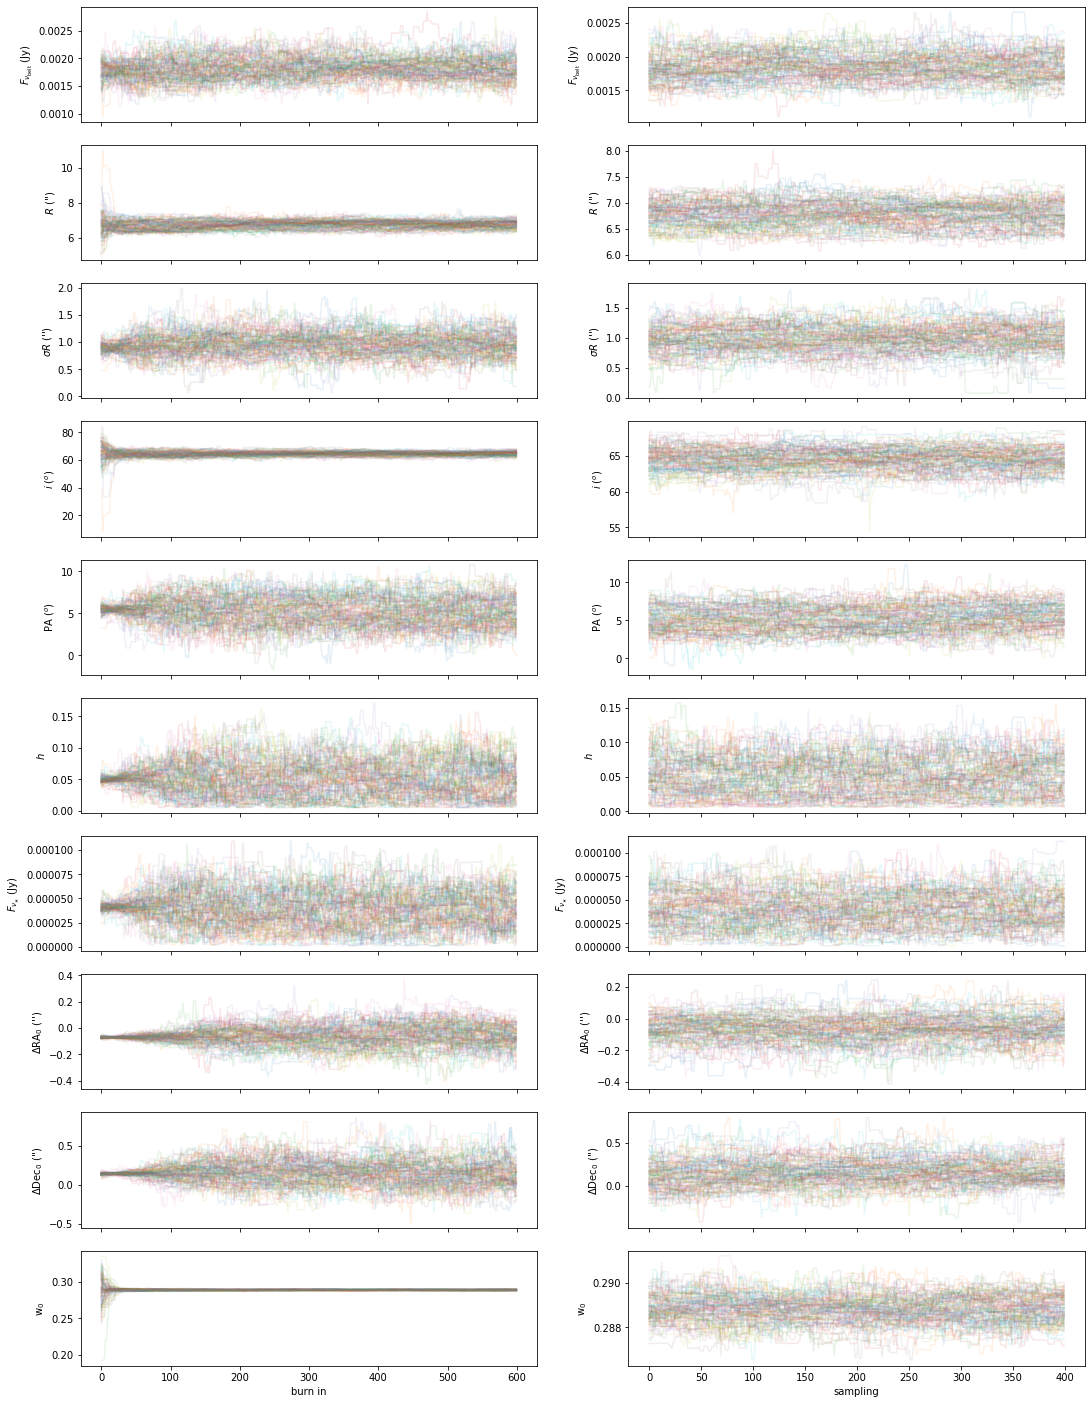

In [9]:
newbackend=False
backendaddress='backend_'+sourcetag+'_todaysdate_computersname.pkl'
pickle.dump([newbackend, backendaddress], open('backendoptions.npy', 'wb'), protocol=2)
%run setup_mcmc
chain=backend.get_chain()
print(chain.shape)
burnin=600

if burnin>=chain.shape[0]:
    import sys
    sys.exit('ERROR: burn-in phase longer than number of steps computed! Reset to smaller value')
    
fig,ax = pl.subplots(ndim,2,figsize=(18,25),sharex='col',sharey=False)
for j in range(chain.shape[1]):
    #ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(chain.shape[2]):
        ax[i,0].plot(chain[:burnin,j,i], alpha=0.2)
        ax[i,0].set_ylabel(labelparams[i])

for j in range(chain.shape[1]):
    #ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(chain.shape[2]):
        ax[i,1].plot(chain[burnin:,j,i], alpha=0.2)
        ax[i,1].set_ylabel(labelparams[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
#fig.savefig(traceplotname+'.pdf')
#pl.close()
#os.system('cp -r '+traceplotname+'.pdf ../plots/.')


If chains look converged for every parameter (you can also use more formal convergence criteria - see e.g. emcee 
documentation), you can be happy and proceed to the next notebook describing postprocessing (Step 3). <br>
If you're not happy, run for longer using:

In [10]:
## If number of steps is insufficient, i.e. if the chains have not converged for each parameter, run for more steps using:
#newbackend=False
#backendaddress='backend_'+sourcetag+'_todaysdate_computersname_v2.pkl'
#pickle.dump([newbackend, backendaddress], open('backendoptions.npy', 'wb'), protocol=2)
#%run setup_mcmc
#nsteps=1000-chain.shape[0] #chain.shape[0] contains the number of steps we have currently run for, and nsteps will be
## the number of steps you want to go further by.
#sampler.run_mcmc(None,nsteps,progress=True)